In [4]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
%matplotlib inline

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. 

$$y_{\alpha,\gamma,\beta}\sim\mbox{binomial}\left( n_{\alpha,\gamma, \beta},p_{\alpha,\gamma,\beta}\right),\mbox{ for } j=1,\dots, J.$$

* $y_{\alpha,\gamma}$ are the responses to a particular product ($\alpha$) at a particular price ($\beta$)and location on shelf ($\gamma$) i.e. `fit`=1 or `does not fit`=0

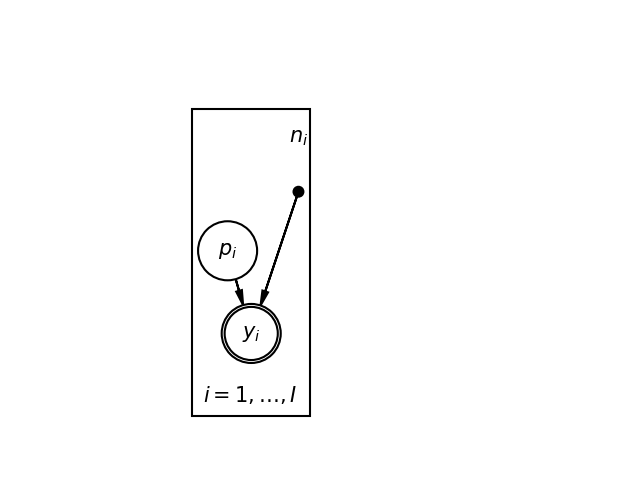

In [59]:
import daft
pgm = daft.PGM(shape=(5,4),observed_style="inner",dpi=150)

pgm.add_node('p',r'$p_i$',1.8,2)
pgm.add_node('n',r'$n_i$',2.4,2.5,fixed=True)

pgm.add_node('y',r'$y_i$',2,1.3,observed=True)
pgm.add_edge('p','y')
pgm.add_edge('n','y')




pgm.add_plate([1.5, 0.7, 1, 2.5], label=r"$i = 1, \ldots, I$", shift=-0.1)
# Render and save.
pgm.render()
pgm.show()

In [20]:
model="""
data{
int N;
int n_abg[N];
int y[N];
int fit;
}

parameters {
real<lower=0,upper=1.0> p[N];

}

model{
  if (fit > 0){

y~binomial(n_abg,p);
}
}

generated quantities {
int y_pred[N];
for (i in 1:N){
y_pred[i]=binomial_rng(n_abg[i], p[i]);
}
}
"""

In [21]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d88c6dcafb11f1ba23a30f5f07ef7c23 NOW.


In [25]:
data={
    'N':10,
    'n_abg':np.full(10,(100)),
    'y':np.full(10,(0)),
    'fit':0
}

In [26]:
fit=sm.sampling(data=data,chains=1,iter=500)

In [28]:
pystan.diagnostics.check_hmc_diagnostics(fit,verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.79) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [34]:
s=0
data={
    'N':10,
    'n_abg':fit.data['n_abg'],
    'y':fit['y_pred'][s,:].astype(int),
    'fit':1
}

In [35]:
fit_prior=sm.sampling(data=data,chains=1,iter=500)

In [36]:
fit_prior

Inference for Stan model: anon_model_d88c6dcafb11f1ba23a30f5f07ef7c23.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]         0.77  2.6e-3   0.04   0.69   0.75   0.77    0.8   0.85    261    1.0
p[2]         0.08  1.2e-3   0.03   0.03   0.06   0.08   0.09   0.13    454    1.0
p[3]         0.62  1.9e-3   0.05   0.53   0.59   0.61   0.65   0.71    569    1.0
p[4]         0.72  1.6e-3   0.04   0.63   0.69   0.72   0.74   0.79    600    1.0
p[5]          0.5  2.0e-3   0.05   0.41   0.47    0.5   0.53   0.59    544    1.0
p[6]          0.8  1.5e-3   0.04   0.71   0.78   0.81   0.83   0.88    700    1.0
p[7]         0.77  1.9e-3   0.04   0.69   0.75   0.78    0.8   0.84    401    1.0
p[8]         0.19  1.9e-3   0.04   0.12   0.16   0.19   0.22    0.3    500    1.0
p[9]         0.87  1.5e-3   0.03    0.8   0.85   0.88    0.9   0.93    499   

In [37]:
p=fit_prior.data['y']/fit.data['n_abg']
error=np.sqrt(p*(1-p)/fit.data['n_abg'])

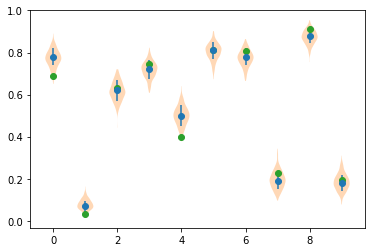

In [47]:
plt.errorbar(np.arange(0,10),p,yerr=error,fmt='o')
plt.violinplot(fit_prior['p'],positions=np.arange(0,10),showextrema=False);
plt.plot(np.arange(0,10),fit['p'][s,:],'o')

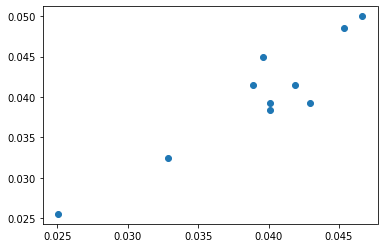

In [45]:
plt.plot(np.std(fit_prior['p'],axis=0),error,'o')